In [22]:
## reweight to a set of cvs not part of intial biased CV set
## follow tutorial 3 walkthrough: https://www.plumed.org/doc-v2.7/user-doc/html/masterclass-21-4.html
## generate distance-based reweighting for inverse distance and nbps figs

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

In [25]:
## just reweight colvars np histograms

def load_colvar(colvar, ncvs=9):
    '''read colvar file and output traj array'''
    
    df = pd.read_csv(colvar, header=0, delim_whitespace=True)
    cols = df.columns[3:]
    data = np.array(df)[:, 1:-2] 
    colvar_dict = {}
    for col, val in zip(cols, data.T):
        colvar_dict[col] = val
    return colvar_dict

def score_all_contacts(dists, base, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by summing all available contacts below respective cutoffs'''
    
    # find possible AT and GC pairs
    complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 0:
        del s1_bps[base-1]

    idx = 0
    all_sums = np.zeros(len(dists))
    for b1 in s1_bps:
        AT_possible, GC_possible = [], []
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
                
        AT_sums = np.sum((dists[:, AT_possible] < AT_cutoff), axis=1) > 0
        GC_sums = np.sum((dists[:, GC_possible] < GC_cutoff), axis=1) > 0
        all_sums += AT_sums + GC_sums        
            
    return all_sums


def translate_pairs(num_bp, base, strand=1, exclude_list=[1, 3, 5]):
    ''' exclude unique distances between base types, 
        translate share coordinates,
        return list of indexs needed to establish a shared basis
       
       Inputs:
       num_bp -- number of base pairs in sequence
       base -- abasic site'''
     
    # account for control
    s1_control = [i*3 + 1 for i in range(num_bp)]
    s2_control = [i*3 + num_bp*3 for i in range(num_bp)]
    
    # make list of excluded bases
    b1_excluded = np.array(s1_control)[exclude_list]
    b1_excluded = list(b1_excluded) + list(b1_excluded - 1)
    
    if base == 0:
        s1 = s1_control
        s2 = s2_control
    else:
        # shift index down for missing bp
        b_idx = base
        s1 = [i*3 + 1 for i in range(b_idx-1)] + [i*3 for i in range(b_idx, num_bp)]
        s2 = s2_control
        
    idx = 0
    idx_list = []
    for b1 in s1:
        for b2 in s2:
            
            # only exclude first strand
            if b1 not in b1_excluded:
                idx_list.append(idx)
            
            idx += 1
    
    return np.array(idx_list)

def nbps_fes_biased(all_wc_nbps, bias, temp, avg_list = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0]):
    '''generate fes from discrete probability density
       average list smoooths over final fractions to improve convergence
       by default, average over last quarter of simulation'''
    
    kb = 8.3124 / 1000
    weights = np.exp(bias/(kB*temp))
    
    prob_list = [] 
    for fract in avg_list:
        i_max = int(len(weights)*fract)
        prob_hist, bins = np.histogram(all_wc_nbps[:i_max], bins=12, weights=weights[:i_max], range=(0, 12)) #(0, 2)
        prob_list.append(prob_hist)
      
    prob_avg = np.array(prob_list).mean(axis=0)
    fes_hist = -kb*temp*np.log(prob_avg)
    fes_hist = fes_hist - fes_hist[0]
    
    return bins[:-1], fes_hist


def bdist_inv_fes_biased(dists, bias, temp, avg_list = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0]):
    '''generate fes from discrete probability density
       average list smoooths over final fractions to improve convergence
       by default, average over last quarter of simulation'''
    
    kb = 8.3124 / 1000
    weights = np.exp(bias/(kB*temp))
    shared_idxs = translate_pairs(11, base)
    wc_idxs = np.array([10,19,28,37,47,57,67,77])
    bdist_inv = 1/np.mean(dists[:, shared_idxs[wc_idxs]], axis=1)
    
    prob_list = [] 
    for fract in avg_list:
        i_max = int(len(weights)*fract)
        prob_hist, bins = np.histogram(bdist_inv[:i_max], bins=100, weights=weights[:i_max], range=(0, 2)) #(0, 2)
        prob_list.append(prob_hist)
        #prob_list.append(pdf(bins[:-1]))
      
    prob_avg = np.array(prob_list).mean(axis=0)
    fes_hist = -kb*temp*np.log(prob_avg)
    fes_hist = fes_hist - np.min(fes_hist[:15])
    
    return bins[:-1], fes_hist

CCTATATATCC 0
CCTATATATCC 2


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


CCTATATATCC 4


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


CCTATATATCC 6


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


CGCATATATAT 0
CGCATATATAT 2


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


CGCATATATAT 4


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


CGCATATATAT 6


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TATAGCGATAT 0
TATAGCGATAT 2


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TATAGCGATAT 4


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TATAGCGATAT 6


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TTTTTTTTTTT 0
TTTTTTTTTTT 2


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TTTTTTTTTTT 4


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


TTTTTTTTTTT 6


<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)
<ipython-input-25-d00afb882083>:97: RuntimeWarning: divide by zero encountered in log
  fes_hist = -kb*temp*np.log(prob_avg)


Text(0, 0.5, '                                                  Free energy (kJ/mol)')

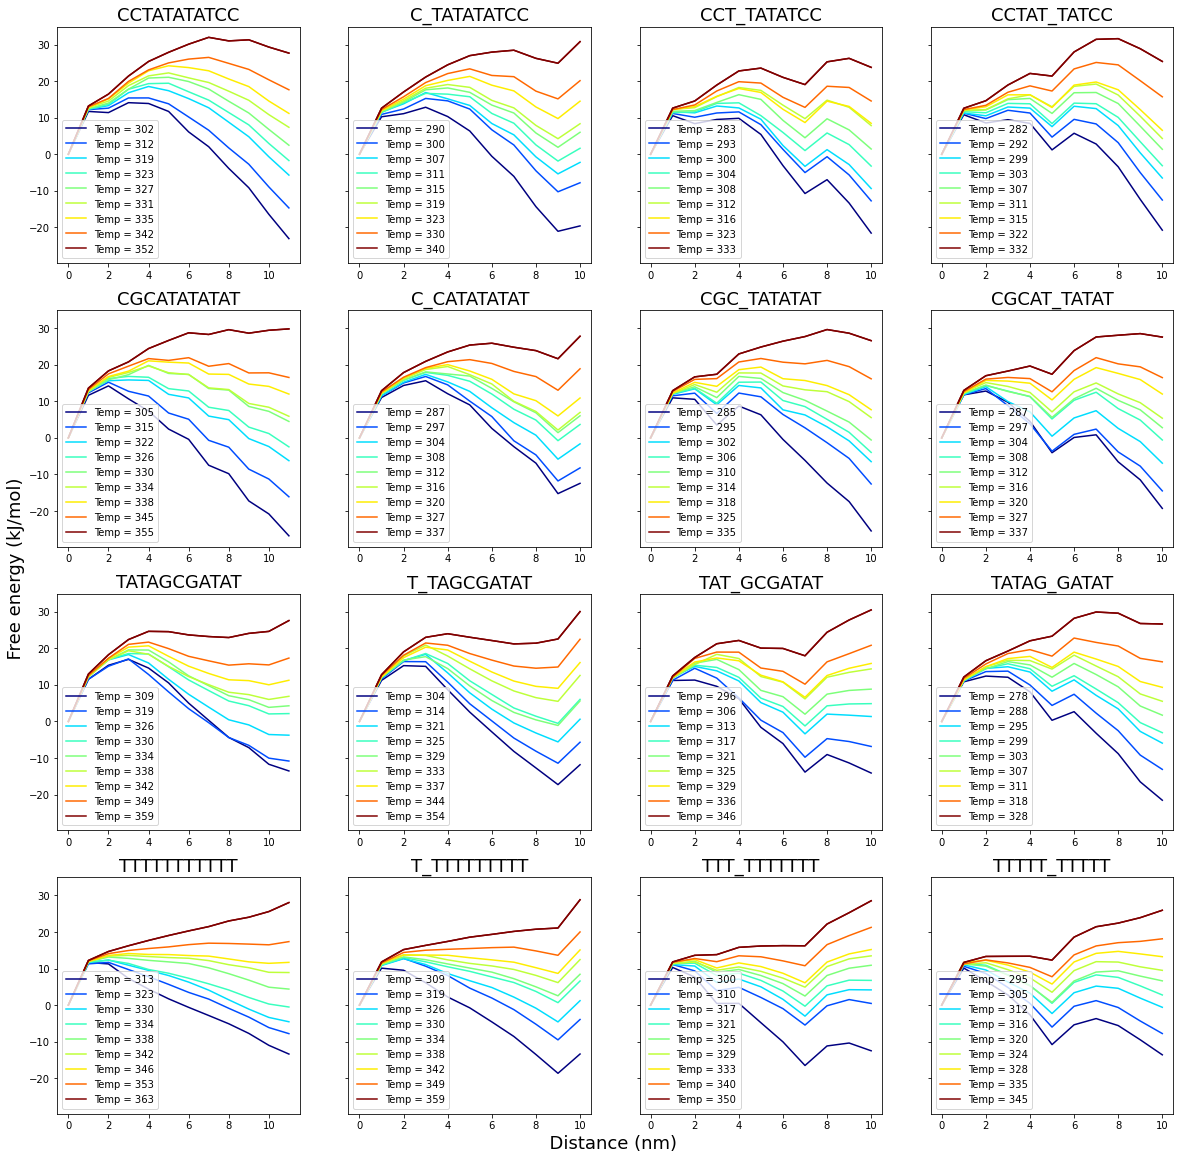

In [26]:
## reweight metad trajectory data into interpretable CVs -- inverse distance and nbps

# use consistent scoreing fucntion for nubmer of bound pairs (only corresponding to one site along the abasic strand)

dpath = './heatmap_distances_vary_temp/'
seq_dir = '../11bp_varyT_s-0.01_bf-4_ns-1e+09/' 
save_dir = 'FES_outs/'

plot_type = 'nbps' #'bdist_inv'
n_bp = 11
pad = 0.3

base_list = [0, 2, 4, 6]
seq_list = ['CCTATATATCC','CGCATATATAT','TATAGCGATAT','TTTTTTTTTTT',]

save_txt = True
subtract_diss = True
use_avg_fes = True
save_txt_path = './save_npbs_and_bdist_invs/'

kB = 1.380 * 6.022 / 1000 #kJ/mol/K
seq_hbr_list = []

fig, axes = plt.subplots(len(seq_list), len(base_list), 
                         figsize=(5*len(base_list), 5*len(seq_list)), sharey=True)

# record difference in theoretical and predicted tm 
tm_fit_list = []
popt_list = []

for ax_row, seq in zip(axes, seq_list):
    for ax, base in zip(ax_row, base_list):
        
        print(seq, base)
        temp_dirs = sorted(glob.glob(f'{seq_dir}{seq}_base-{base}*'))
        plot_temps = [int(td[-3:]) for td in temp_dirs]
        FES_list = []
        
        # normalize color map with temp
        normalize = mcolors.Normalize(
            vmin=np.min(plot_temps), vmax=np.max(plot_temps))
        colormap = cm.jet
        
        if base==0: abasic_label= seq
        else:       abasic_label= f'{seq[:base-1]}_{seq[base:]}'
        
        for temp, t_dir in zip(plot_temps, temp_dirs):
            
            # load all pairwise distances
            dists_path = glob.glob(f'{dpath}*{seq}*b{base}*T-{temp}*')[0]
            temp = int(dists_path.split('_T-')[-1][:3])
            dists = np.load(dists_path)
            
            # get bias from colvars:
            colvar_dict = load_colvar(f'{t_dir}/COLVAR')
            bias = colvar_dict['metad.bias'][::2]
            
            # get all wc pairs for nbps plots:
            if plot_type == 'nbps':
                all_wc_nbps = score_all_contacts(dists, base, AT_cutoff=0.6+pad, GC_cutoff=0.55+pad)
                bins, fes = nbps_fes_biased(all_wc_nbps, bias, temp)
                
            # compute inverse average dist
            elif plot_type == 'bdist_inv':
                bins, fes = bdist_inv_fes_biased(dists, bias, temp)
            
            # plot fes and color by temp
            ax.plot(bins, fes, label=f'Temp = {temp}', color=colormap(normalize(temp)))

            # save to output files
            if save_txt:
                with open(f'{save_txt_path}{plot_type}_bins.txt', 'w') as f:
                    bins_str = [str(x) for x in bins]
                    f.writelines('\n'.join(bins_str))
                with open(f'{save_txt_path}{plot_type}_{seq}_base-{base}_temp-{temp}.txt', 'w') as f:
                    fes_str = [str(x) for x in fes]
                    f.writelines('\n'.join(fes_str))

        # setup the colorbar
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(np.arange(290, 338))
        ax.legend(loc='lower left')
        
        # add titles
        ax.plot(bins, fes, label=f'Temp = {temp}', color=colormap(normalize(temp)))
        if base==0: abasic_label= seq
        else:       abasic_label= f'{seq[:base-1]}_{seq[base:]}'
        ax.set_title(abasic_label, fontsize=18)
        

spaces = ' '*50
axes[-1, 1].set_xlabel(f'{spaces}Distance (nm)', fontsize=18)
axes[2, 0].set_ylabel(f'{spaces}Free energy (kJ/mol)', fontsize=18)


In [ ]:
## (old version of above) uses colvar data only

def add_nbps(colvar_dict, bp_cutoff=0.8):
    '''add number of base pair coordinate based on distance cutoff'''
    
    nbps_list = []
    for cv, traj in colvar_dict.items():
        nbps = 1
        if 'p' in cv:
            dtraj = traj < bp_cutoff
            nbps_list.append(dtraj)
            
    total_nbps = np.array(nbps_list).sum(axis=0)
    print(np.shape(nbps_list), np.shape(total_nbps), total_nbps[:2])
    colvar_dict[f'nbps_cut-{bp_cutoff}'] = total_nbps
    return colvar_dict
    

def convert_to_fes(colvar_dict, temp, gmin=0.0, gmax=5.0, nbins=200):
    '''convert each cv in colvar to fes'''
    
    R = 8.3124 / 1000
    bias = colvar_dict['metad.bias']
    weights = np.exp(bias/(R*temp))
    
    fes_dict = {}
    nbps_list = []
    
    for cv, traj in colvar_dict.items():
        nbps = 1
        if 'p' in cv:
            print(np.shape(traj), np.shape(weights), traj[0])

            prob_hist, bins = np.histogram(traj, bins=nbins, range=(gmin, gmax), weights=weights, density=False)
            fes_hist = -R*temp*np.log(prob_hist) 
            fes_dict[cv] = fes_hist
    
    return bins, fes_dict

def plot_fes(bins, fes, ax):
    '''plot each fes on a given axis'''
    
    pass


seq_dir = '../11bp_varyT_s-0.01_bf-4_ns-1e+09/' 
save_dir = 'FES_outs/'
n_bp = 11

base_list = [0, 2, 4, 6]
seq_list = ['CCTATATATCC','CGCATATATAT','TATAGCGATAT','TTTTTTTTTTT',]

# for determining H vs. D regions
hbr_cutoff = 2
diss_max = 7.5

save_txt = False
subtract_diss = True
use_avg_fes = True
save_txt_path = './Brennan_FES_temps/'
avg_name = 'fes_15_20_avg.npy'

kB = 1.380 * 6.022 / 1000 #kJ/mol/K
seq_hbr_list = []

fig, axes = plt.subplots(len(seq_list), len(base_list), 
                         figsize=(5*len(base_list), 5*len(seq_list)), sharey=True)

# record difference in theoretical and predicted tm 
tm_fit_list = []
popt_list = []

for ax_row, seq in zip(axes, seq_list):
    for ax, base in zip(ax_row, base_list):
        
        # get temps for each seq and base combination
        temp_dirs = sorted(glob.glob(f'{seq_dir}{seq}_base-{base}*'))
        plot_temps = [int(td[-3:]) for td in temp_dirs]
        FES_list = []
        
        # normalize color map with temp
        normalize = mcolors.Normalize(
            vmin=np.min(plot_temps), vmax=np.max(plot_temps))
        colormap = cm.jet
        
        if base==0: abasic_label= seq
        else:       abasic_label= f'{seq[:base-1]}_{seq[base:]}'
        
        for temp, t_dir in zip(plot_temps, temp_dirs):
            colvar_dict = load_colvar(f'{t_dir}/COLVAR')
            colvar_dict = add_nbps(colvar_dict, bp_cutoff=0.8)
            bins, fes_dict = convert_to_fes(colvar_dict, temp, gmin=0, gmax=12, nbins=11)
            
            ax.plot(bins[:-1], fes_dict['nbps_cut-0.8'], label=f'Temp = {temp}', color=colormap(normalize(temp)))

            # save to output files
            if save_txt:
                with open(f'{save_txt_path}bins.txt', 'w') as f:
                    cv_str = [str(x) for x in cv]
                    f.writelines('\n'.join(cv_str))
                with open(f'{save_txt_path}{seq}_base-{base}_temp-{temp1}.txt', 'w') as f:
                    fe_str = [str(x) for x in fe]
                    f.writelines('\n'.join(fe_str))

        # setup the colorbar
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(np.arange(290, 338))
        ax.legend()
        #plt.colorbar(scalarmappaple)


spaces = ' '*50
axes[-1, 1].set_xlabel(f'{spaces}Distance (nm)', fontsize=18)
axes[2, 0].set_ylabel(f'{spaces}Free energy (kJ/mol)', fontsize=18)
